# i. Perkenalan
Marchelly Gideon Tambunan\

- Dataset: Census Adult Income
- Objektif: Buatlah model Classification menggunakan Logistic Regression dan SVM untuk memprediksi income bracket menggunakan dataset yang sudah kalian simpan.

# ii. SQL Query

SELECT 
age, 
workclass, 
education, 
education_num, 
marital_status, 
occupation, 
relationship, 
race, 
sex, 
capital_gain, 
capital_loss, 
hours_per_week, 
native_country, 
income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income` 
WHERE workclass != ' ?' 
and hours_per_week < 100
LIMIT 7996

# iii. Import Libraries

In [133]:
# Data Loading
import pandas as pd
from pandas.api.types import CategoricalDtype

#Importing Warning filtering
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

# Feature Selection (manual)
import numpy as np

# Model Definition
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Model Inference
import joblib
import json

# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# iv. Data Loading

load data dengan menambah parameter missing value `" ?"` karena setelah melakukan pengecekan data singkat pada big query ada missing value berupa `" ?"`pada kolom workclass. jadi lebih baik saya mengecek kembali pada bagian data loading

In [134]:
# Data Loading
df = pd.read_csv('C:\H8_project\Hacktiv8_GC\GC2\h8dsft_P1G2_Marchelly_Gideon.csv',na_values=[" ", "-", "?" ,"n/a", "na", "--"," ?"])
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7988 entries, 0 to 7987
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             7988 non-null   int64 
 1   workclass       7988 non-null   object
 2   education       7988 non-null   object
 3   education_num   7988 non-null   int64 
 4   marital_status  7988 non-null   object
 5   occupation      7983 non-null   object
 6   relationship    7988 non-null   object
 7   race            7988 non-null   object
 8   sex             7988 non-null   object
 9   capital_gain    7988 non-null   int64 
 10  capital_loss    7988 non-null   int64 
 11  hours_per_week  7988 non-null   int64 
 12  native_country  7867 non-null   object
 13  income_bracket  7988 non-null   object
dtypes: int64(5), object(9)
memory usage: 873.8+ KB


In [136]:
# Missing value
df.isna().sum()

age                 0
workclass           0
education           0
education_num       0
marital_status      0
occupation          5
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    121
income_bracket      0
dtype: int64

In [137]:
# melihat ada berapa persen missing value pada tiap kolom
percent_missing = df.isnull().sum() * 100 / len(df)                     
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
age,0.000000
workclass,0.000000
education,0.000000
education_num,0.000000
marital_status,0.000000
occupation,0.062594
relationship,0.000000
race,0.000000
sex,0.000000
capital_gain,0.000000


karena missing value yang ada pada data tergolong sedikit, jadi kita akan lansung membuangnya

In [138]:
# menghapus missing value
df.dropna(axis=0,inplace = True)
df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,33,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
7984,36,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,2885,0,40,United-States,<=50K
7985,29,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
7986,48,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [139]:
df.isna().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

In [140]:
data = df.copy()

sekarang data sudah tidak ada missing value, selanjutnya kita akan melihat apakah ada data yang duplikat

In [141]:
# cek duplikat data
data.duplicated().sum()

1107

ternyata ada 1187 duplikasi data. jadi kita akan menghapus duplikasi data tersebut

In [142]:
# melihat duplikat data
duplic = data[data.duplicated()]
duplic

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
31,44,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0,0,40,United-States,<=50K
89,61,Private,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
116,42,Private,9th,5,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
131,25,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,Mexico,<=50K
203,35,Self-emp-not-inc,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7942,54,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K
7966,55,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
7970,56,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
7977,29,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [143]:
# menghapus index data
data.drop(duplic.index, axis = 0, inplace=True)

data duplikat telah dihapus. namun kita harus pastikan kembali data tersebut

In [144]:
# cek duplikadt data
data.duplicated().sum()

0

sekarang kita akan melakukan reset index agar index pada data tidak ada yang hilang

In [145]:
# reset index
data.reset_index()
data.shape

(6755, 14)

# v. Exploratory Data Analysis (EDA)

pada bagian ini, kita akan melakukan beberapa eksplorasi data agar lebih mudah memahami data yang kita miliki

pertama kita akan melihat unique values pada income bracket

In [146]:
print(f'income_bracket unique values: {data.income_bracket.unique()}')

income_bracket unique values: [' <=50K' ' >50K']


ternyata kolom income_bracket memiliki 2 unique values. namun, sepertinya ada yang salah dengan data yang kita miliki, karena ada whitespace pada setiap index. sepertinya itu cukup menyulitkan kita untuk melakukan proses selanjutnya. jadi kita akan menghapus setiap whitespace yang ada

In [147]:
data = data.replace(' ', '',regex=True)

mari kita pastikan kembali agar tidak ada kesulitan

In [148]:
print(f'income_bracket unique values: {data.income_bracket.unique()}')

income_bracket unique values: ['<=50K' '>50K']


sekarang kita akan melihat ada berapa jumlah orang pada setiap edukasinya berdasarkan usia

In [149]:
edu = data.groupby('education')[['age']].count().sort_values('education')
edu

,age
education,
10th,770
11th,941
12th,358
1st-4th,149
5th-6th,283
7th-8th,541
9th,449
HS-grad,3264


In [150]:
edu_num = data.groupby('education_num')[['age']].count().sort_values('education_num')
edu_num

,age
education_num,
2,149
3,283
4,541
5,449
6,770
7,941
8,358
9,3264


ternyata dari pada kolom education maupun education_num memiliki jumlah yang sama pada setiap unique values.

selanjutnya kita akan melihat occupation berdasarkan usia

In [151]:
ocu = data.groupby('occupation')[['age']].count().sort_values('age')
ocu

,age
occupation,
Armed-Forces,1
Priv-house-serv,70
Tech-support,84
Protective-serv,142
Prof-specialty,150
Farming-fishing,398
Exec-managerial,476
Adm-clerical,483
Handlers-cleaners,493


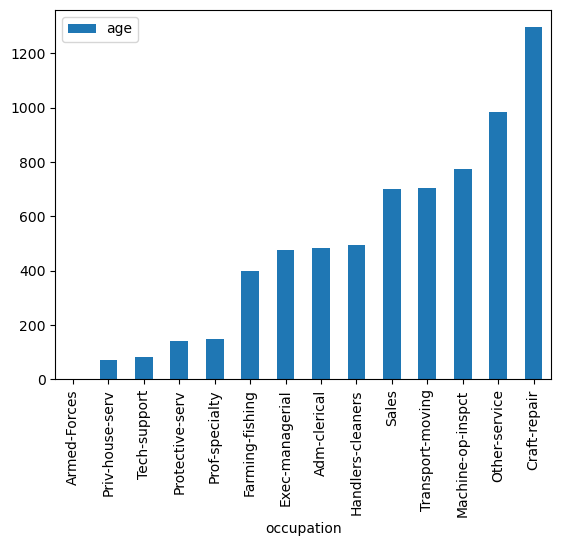

In [152]:
data.groupby('occupation')[['age']].count().sort_values(by='age').plot(kind='bar');

dari hasil diatas dapat terlihat yang paling banyak adalah craft-repair

In [153]:
rel = data.groupby('relationship')[['age']].count().sort_values('age')
rel

,age
relationship,
Other-relative,220
Unmarried,440
Wife,544
Own-child,688
Not-in-family,749
Husband,4114


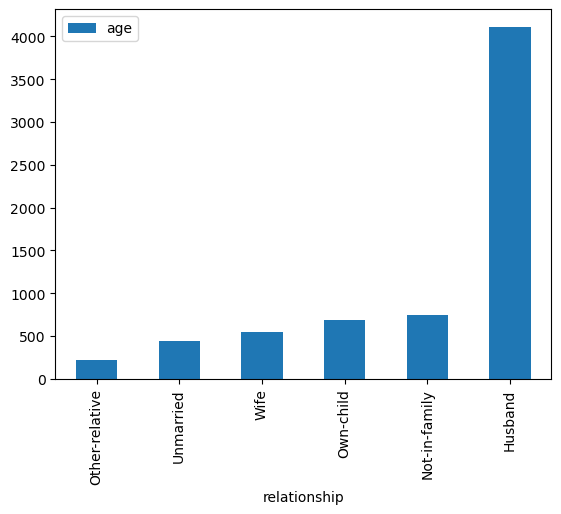

In [154]:
data.groupby('relationship')[['age']].count().sort_values(by='age').plot(kind='bar');

dari status perkawinan diatas terlihat yang banyak sebagai suami

<AxesSubplot:xlabel='sex'>

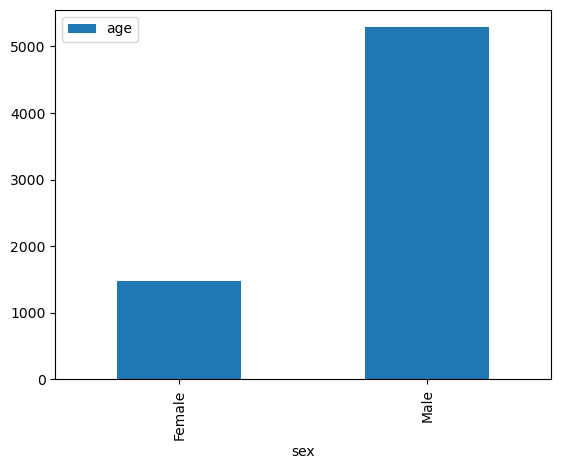

In [155]:
data.groupby('sex')[['age']].count().sort_values(by='age').plot(kind='bar')

dari sex paling banyak berada pada jenis kelamin laki-laki

# vi. Preproccessing/Feature Engineering

pada bagian ini kita akan menyiapkan data berupa pemilihan features, data spliting, dll

### Features Selection

sebelum kita memilih fitur apa saja yang akan dijadikan target. kita akan melihat terlebih dahulu korelasi antar kolom terhadap income_bracket

In [156]:
data.phik_matrix().loc['income_bracket'].sort_values(ascending=False)

interval columns not set, guessing: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


income_bracket    1.000000
education         0.509211
education_num     0.509211
relationship      0.443380
occupation        0.346531
age               0.340184
hours_per_week    0.312144
marital_status    0.294440
capital_gain      0.270898
sex               0.201036
native_country    0.173276
workclass         0.156763
capital_loss      0.133562
race              0.077436
Name: income_bracket, dtype: float64

hasil diatas dapat terlihat korelasi antar kolom terhadap income_bracket. kita akan mengambil kolom yang memiliki korelasi lebih dari 0.3 kecuali kolom education_num karena memiliki korelasi dan nilai yang sama dengan education

In [157]:
data_clean = data[['education', 'relationship', 'occupation','age', 'hours_per_week','income_bracket']]
data_clean

,education,relationship,occupation,age,hours_per_week,income_bracket
0,9th,Wife,Other-service,39,34,<=50K
1,9th,Wife,Priv-house-serv,77,10,<=50K
2,9th,Wife,Other-service,38,24,<=50K
3,9th,Wife,Protective-serv,28,40,<=50K
4,9th,Wife,Machine-op-inspct,37,48,<=50K
...,...,...,...,...,...,...
7982,HS-grad,Husband,Craft-repair,42,40,<=50K
7983,HS-grad,Husband,Craft-repair,33,40,<=50K
7984,HS-grad,Husband,Craft-repair,36,40,<=50K
7986,HS-grad,Husband,Craft-repair,48,40,<=50K


### Cardinality Checking

selanjutnya kita akan mengecek kolom yang memiliki cardinalitas yang tinggi

In [158]:
data_clean.select_dtypes('object').nunique()

education          8
relationship       6
occupation        14
income_bracket     2
dtype: int64

ternyata ada kolom yang memiliki kardinalitas tinggi yaitu occupation, education, dan relationship. jadi kita akan melakukan handling cardinality pada kolom tersebut

In [159]:
data_clean[['occupation']] = data_clean[['occupation']].replace(['Craft-repair','Other-service','Protective-serv',
                                                 'Handlers-cleaners', 'Priv-house-serv'], 'Service')

In [160]:
# mengurangi Cardinality
data_clean[['education']] = data_clean[['education']].replace(['7th-8th','5th-6th','1st-4th'], 'Junior School')
data_clean[['education']] = data_clean[['education']].replace(['11th','10th','9th'], 'Mid School')
data_clean[['education']] = data_clean[['education']].replace(['12th','HS-grad'], 'Hi School')

In [161]:
# Mengurangi relationship
data_clean[['relationship']] = data_clean[['relationship']].replace(['Not-in-family','Unmarried'], 'Single')
data_clean[['relationship']] = data_clean[['relationship']].replace(['Own-child','Other-relative', 'Wife', 'Husband'], 'Have Family')

In [162]:
# mengganti tipe data
data_clean['relationship'] = data_clean['relationship'].astype('category')
data_clean['education'] = data_clean['education'].astype('category')

sekarang kita cek kembali kardinalitas tiap kolom

In [163]:
# reset index
data_clean.reset_index(inplace=True, drop=True)

terlihat pada setiap kolom memiliki kardinalitas yang cukup normal

### Train Test Split

sekarang kita akan memisahkan kolom menjadi x dan y. x berisi fitur dan y berisi target

In [164]:
# memilih fitur
x = data_clean.drop('income_bracket', axis = 1)
y = data_clean['income_bracket']
x

,education,relationship,occupation,age,hours_per_week
0,Mid School,Have Family,Service,39,34
1,Mid School,Have Family,Service,77,10
2,Mid School,Have Family,Service,38,24
3,Mid School,Have Family,Service,28,40
4,Mid School,Have Family,Machine-op-inspct,37,48
...,...,...,...,...,...
6750,Hi School,Have Family,Service,42,40
6751,Hi School,Have Family,Service,33,40
6752,Hi School,Have Family,Service,36,40
6753,Hi School,Have Family,Service,48,40


sekarang kita akan membuat train test split pada data

In [165]:
# train test split
x_train,x_test, y_train,y_test= train_test_split(x,y, test_size=0.1, random_state=2)
print(f'dimensi x_train: {x_train.shape}')
print(f'dimensi x_test: {x_test.shape}')
print(f'dimensi y_train: {y_train.shape}')
print(f'dimensi y_train: {y_test.shape}')

dimensi x_train: (6079, 5)
dimensi x_test: (676, 5)
dimensi y_train: (6079,)
dimensi y_train: (676,)


In [166]:
# memilih kolom numerik, objek dan kategorikal 
num_col = x_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_col = x_train.select_dtypes(include=['object']).columns.tolist()
ord_col = x_train.select_dtypes(include=['category']).columns.tolist()

print(f'Number of numerical columns: {len(num_col)}')
print(f'Numerical columns: {num_col}')
print(f'Number of categorical columns: {len(cat_col)}')
print(f'Categorical columns: {cat_col}')
print(f'Number of Ordinal columns: {len(ord_col)}')
print(f'Ordinal columns: {ord_col}')

x_train_num = x_train[num_col]
x_train_cat = x_train[cat_col]
x_train_ord = x_train[ord_col]

x_test_num = x_test[num_col]
x_test_cat = x_test[cat_col]
x_test_ord = x_test[ord_col]

Number of numerical columns: 2
Numerical columns: ['age', 'hours_per_week']
Number of categorical columns: 1
Categorical columns: ['occupation']
Number of Ordinal columns: 2
Ordinal columns: ['education', 'relationship']


### Handling Outlier

setelah kita melakukan train test split, kita akan melakukan handling outlier pada kolom numerik

In [167]:
x_train.age.skew()

0.28216940908335536

In [168]:
x_train.hours_per_week.skew()

0.45195603175599797

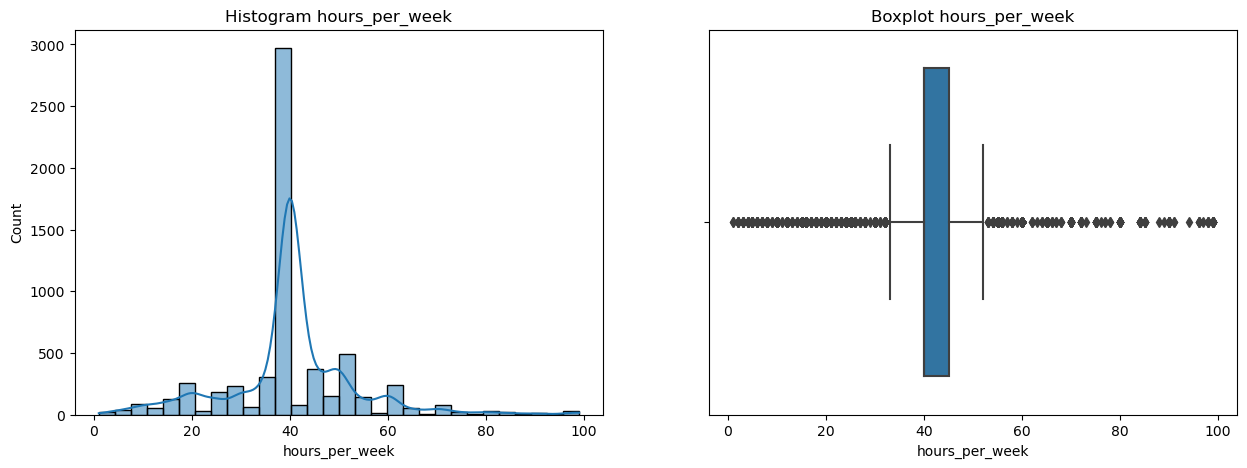

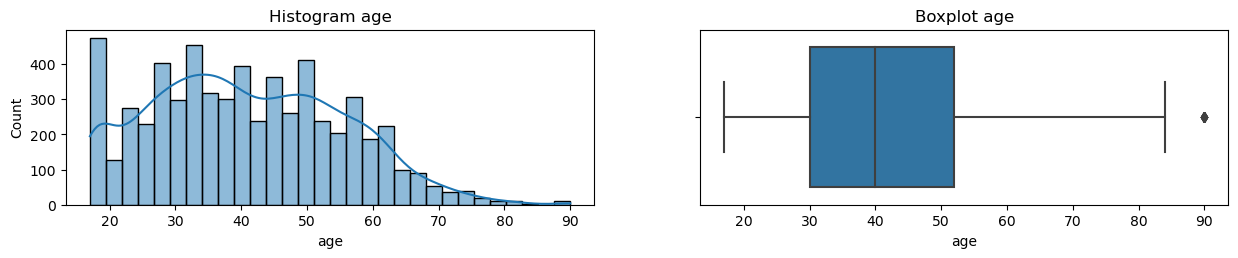

In [169]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(x_train['hours_per_week'],kde=True,bins =30)
plt.title('Histogram hours_per_week')

plt.subplot(1,2,2)
sns.boxplot(x_train['hours_per_week'])
plt.title('Boxplot hours_per_week');

plt.figure(figsize=(15,5))
plt.subplot(2,2,3)
sns.histplot(x_train['age'],kde=True,bins =30)
plt.title('Histogram age')

plt.subplot(2,2,4)
sns.boxplot(x_train['age'])
plt.title('Boxplot age');

karena pada hasil visualisasi diatas terdapat banyak sekali outlier. jadi kita akan melakukan censoring menggunakan winsorizer

karena nilai skew dapat dibilang cukup normal jadi kita menggunakan metode gaussian

In [170]:
winsoriser = Winsorizer(capping_method='gaussian', 
                          tail='both', 
                          fold=3,
                          variables=['hours_per_week'])

x_train_num_win = winsoriser.fit_transform(x_train_num)
x_test_num_win = winsoriser.transform(x_test_num)

In [171]:
print('x_train - Before Capping')
print(x_train_num.describe())
print('x_train - After Capping')
print(x_train_num_win.describe())
print('x_test - Before Capping')
print(x_test_num.describe())
print('X_test - After Capping')
print(x_test_num_win.describe())

x_train - Before Capping
               age  hours_per_week
count  6079.000000     6079.000000
mean     40.846356       40.352196
std      14.497328       12.940335
min      17.000000        1.000000
25%      30.000000       40.000000
50%      40.000000       40.000000
75%      52.000000       45.000000
max      90.000000       99.000000
x_train - After Capping
               age  hours_per_week
count  6079.000000     6079.000000
mean     40.846356       40.212925
std      14.497328       12.426961
min      17.000000        1.534383
25%      30.000000       40.000000
50%      40.000000       40.000000
75%      52.000000       45.000000
max      90.000000       79.170009
x_test - Before Capping
              age  hours_per_week
count  676.000000      676.000000
mean    40.326923       40.267751
std     14.589634       13.423061
min     17.000000        4.000000
25%     29.000000       40.000000
50%     39.000000       40.000000
75%     51.000000       45.000000
max     82.000000       9

terjadi sedikit perubahan pada statistik deskriptif sebelum dan sesudah censoring

mari kita lanjut ke langkah selanjutnya

In [172]:
# y_train = y_train[y_train.index.isin(x_train.index)]

### Features Scaling

pada langkah ini kita akan melakukan scaling pada kolom numerik yang telah kita handling outlier

In [173]:
x_train_num

,age,hours_per_week
4061,21,40
4162,45,40
4597,24,45
2012,35,90
4402,31,40
...,...,...
6443,45,48
3606,60,40
5704,43,48
6637,37,72


metode scaling yang akan kita pakai adalah metode standard scaler karena outlier yang ada telah kita lakukan Censoring

In [174]:
scaler = StandardScaler()

x_train_num = scaler.fit_transform(x_train_num_win)
x_test_num_ = scaler.transform(x_test_num_win)

In [175]:
x_train_num_sc = pd.DataFrame(x_train_num, columns=num_col)
x_test_num_sc = pd.DataFrame(x_test_num, columns=num_col)

### Features Encoding

setelah tadi kita lakukan scaling pada kolom numerik. selanjutnya kita akan melakukan encoding pada kolom kategorikal

kita akan memakai 2 metode pada encoding yaitu ordinal encoder dan one hot encoder. pada one hot encoder kita gunakan pada kolom occupation. pada ordinal encoder kita gunakan pada kolom relationship dan education

In [176]:
ohe = OneHotEncoder(sparse=False)
ord = OrdinalEncoder()

In [177]:
# Cat_col
x_train_cat_ohe = ohe.fit_transform(x_train_cat)
x_test_cat_ohe = ohe.transform(x_test_cat)

# Ord_col
x_train_cat_ord = ord.fit_transform(x_train_ord)
x_test_cat_ord = ord.transform(x_test_ord)

setelah kita melakukan encoding, saatnya kita memasukkan hasil encoding pada datafrane

In [178]:
x_train_cat_df = pd.DataFrame(x_train_cat_ohe, columns=ohe.get_feature_names(cat_col))
x_test_cat_df = pd.DataFrame(x_test_cat_ohe, columns=ohe.get_feature_names(cat_col))
x_train_cat_df1 = pd.DataFrame(x_train_cat_ord, columns=ord_col)
x_test_cat_df1 = pd.DataFrame(x_test_cat_ord, columns=ord_col)

x_test_cat_df

,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Machine-op-inspct,occupation_Prof-specialty,occupation_Sales,occupation_Service,occupation_Tech-support,occupation_Transport-moving
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
671,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
672,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
673,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Concat between Numeric Columns and Categorical Columns

setelah itu kita akan menggabungkan hasil encoding dan scaling yang telah kita lakukan

In [179]:
x_train_final = pd.concat([x_train_num_sc, x_train_cat_df,x_train_cat_df1], axis=1)
x_test_final = pd.concat([x_test_num_sc.reset_index(drop=True), x_test_cat_df,x_test_cat_df1], axis=1)
x_train_final

,age,hours_per_week,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Machine-op-inspct,occupation_Prof-specialty,occupation_Sales,occupation_Service,occupation_Tech-support,occupation_Transport-moving,education,relationship
0,-1.369079,-0.017136,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.286535,-0.017136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.162127,0.385249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.403304,3.135142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
4,-0.679240,-0.017136,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.286535,0.626679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6075,1.321293,-0.017136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6076,0.148567,0.626679,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6077,-0.265337,2.558123,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
x_test_final

,age,hours_per_week,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Machine-op-inspct,occupation_Prof-specialty,occupation_Sales,occupation_Service,occupation_Tech-support,occupation_Transport-moving,education,relationship
0,60,35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,55,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
2,27,40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,19,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,47,55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
672,52,40,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
673,65,40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
674,26,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


### VIF Check

setelah kita menggabungkan hasil scaling dan encoding. kita akan mengecek VIF(variance inflation factor). disini kita tidak menggunakan hasil dari one hot encoding karena akan membuat hasil menjadi tidak bagus

In [181]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [182]:
calc_vif(x_train_final[['age','hours_per_week', 'education', 'relationship']])

,variables,VIF
0,age,1.019337
1,hours_per_week,1.023717
2,education,1.459906
3,relationship,1.416710


disini hasil nya adalah kolom yang kita gunakan memiliki tingkat kesamaan yang tinggi

# vii. Model Definition

disini kita akan mendefinisikan model yang kita gunakan adalah logistic regression model dan support vector machine sesuai dengan tugas yang diberikan. dengan membuat parameter yang akan dicoba

In [183]:
# Train memakai LogisticRegression
log_model = LogisticRegression(max_iter=1000000)

# Train memakai SVC
svm_clf = SVC(kernel="rbf", C=1)

# viii. Model Training

sekarang kita akan melakukan fit pada model agar model dapat mempelajari data yang ada

In [184]:
# Train model Logistic Regression

log_model.fit(x_train_final, y_train)

LogisticRegression(max_iter=1000000)

In [185]:
# Train model SVC

svm_clf.fit(x_train_final, y_train)

SVC(C=1)

# ix. Model Evaluation

sekarang kita akan mengevaluasi model menggunakan beberapa metric yang biasa digunakan dalam model klasifikasi

### Logistic Regression Model

In [186]:
y_pred_train = log_model.predict(x_train_final)
y_pred_test = log_model.predict(x_test_final)

print('accuracy score train : ',accuracy_score(y_train,y_pred_train))
print('accuracy score test : ',accuracy_score(y_test,y_pred_test),'\n')

accuracy score train :  0.7894390524757361
accuracy score test :  0.1834319526627219 



In [187]:
print('classification report train : \n',classification_report(y_train,y_pred_train),'\n')
print('classification report test : \n',classification_report(y_test,y_pred_test))

classification report train : 
               precision    recall  f1-score   support

       <=50K       0.81      0.95      0.88      4739
        >50K       0.56      0.22      0.32      1340

    accuracy                           0.79      6079
   macro avg       0.68      0.59      0.60      6079
weighted avg       0.76      0.79      0.75      6079
 

classification report test : 
               precision    recall  f1-score   support

       <=50K       0.00      0.00      0.00       552
        >50K       0.18      1.00      0.31       124

    accuracy                           0.18       676
   macro avg       0.09      0.50      0.15       676
weighted avg       0.03      0.18      0.06       676



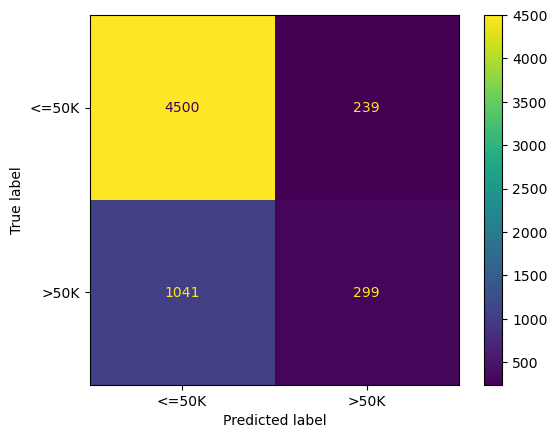

In [188]:
matrix_log_reg_train = confusion_matrix(y_train, y_pred_train, labels=log_model.classes_)
cmd_reg_train = ConfusionMatrixDisplay(confusion_matrix=matrix_log_reg_train,display_labels=log_model.classes_)

cmd_reg_train.plot()
plt.show()

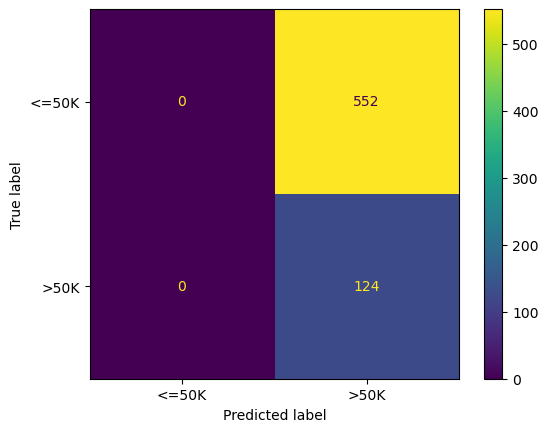

In [189]:
cm_log_reg_test = confusion_matrix(y_test, y_pred_test, labels=log_model.classes_)
disp_log_reg_test = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_test,display_labels=log_model.classes_)

disp_log_reg_test.plot()
plt.show()

### SVM Model

In [190]:
# Predict SVM model
y_pred_train_svm = svm_clf.predict(x_train_final)
y_pred_test_svm = svm_clf.predict(x_test_final)

# Display SVM accuracy
print('accuracy score train : ',accuracy_score(y_train, y_pred_train_svm))
print('accuracy score test : ',accuracy_score(y_test, y_pred_test_svm),'\n')

accuracy score train :  0.7989800954104294
accuracy score test :  0.8165680473372781 



In [191]:
# Display SVM Classification Report
print('classification report train : \n', classification_report(y_train, y_pred_train_svm),'\n')
print('classification report test : \n', classification_report(y_test, y_pred_test_svm))

classification report train : 
               precision    recall  f1-score   support

       <=50K       0.81      0.97      0.88      4739
        >50K       0.63      0.21      0.32      1340

    accuracy                           0.80      6079
   macro avg       0.72      0.59      0.60      6079
weighted avg       0.77      0.80      0.76      6079
 

classification report test : 
               precision    recall  f1-score   support

       <=50K       0.82      1.00      0.90       552
        >50K       0.00      0.00      0.00       124

    accuracy                           0.82       676
   macro avg       0.41      0.50      0.45       676
weighted avg       0.67      0.82      0.73       676



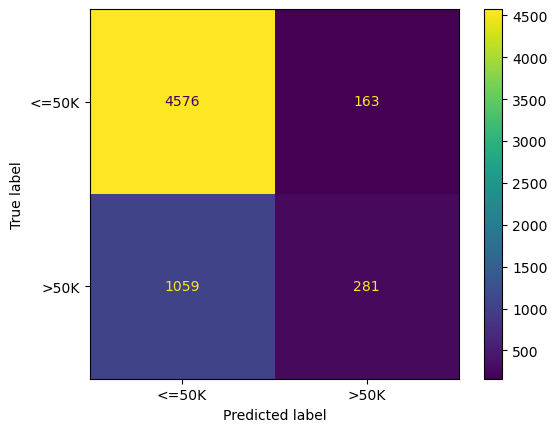

In [192]:
# Display SVM Confusion matrix - Train

matrix_svm_train = confusion_matrix(y_train, y_pred_train_svm, labels=svm_clf.classes_)
cmd_svm_train = ConfusionMatrixDisplay(confusion_matrix=matrix_svm_train,display_labels=svm_clf.classes_)

cmd_svm_train.plot()
plt.show()

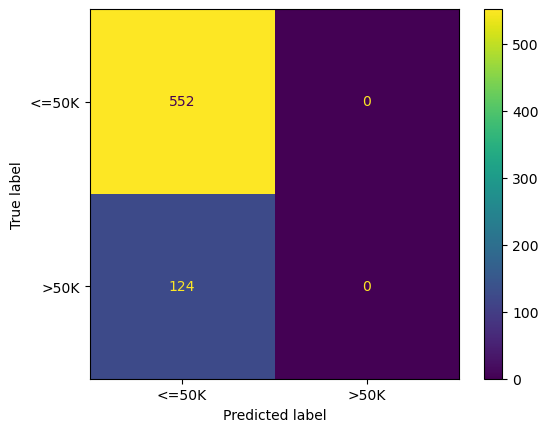

In [193]:
# Display SVM Confusion matrix - Test

matrix_svm_test = confusion_matrix(y_test, y_pred_test_svm, labels=svm_clf.classes_)
cmd_svm_test = ConfusionMatrixDisplay(confusion_matrix=matrix_svm_test,display_labels=svm_clf.classes_)

cmd_svm_test.plot()
plt.show()

# x. Model Analysis

1. Logistic Regression

- model ini dapat terbilang bagus. tetapi, jika dilihat akurasi test nya, dapat dibilang data yang kita miliki adalah imbalance. jika kita hanya menggunakan akurasi tersebut, dapat menyebabkan hasil yang mungkin salah

- hasil recall kita cukup rendah yang berarti model yang kita buat salah dalam memprediksi

- model ini dapat dibilang tidak cukup baik untuk memprediksi hasil kita karena hasil prediksi dapat dibilang salah

2. SVM

- dari hasil svm, model yang kita buat hasilnya 80% yang berarti cukup bagus. namun data yang kita miliki adalah imbalance yang dapat terjadi kesalahan dalam memprediksi data kita

- model ini lebuh baik apabila dibandingkan dengan model sebelumnya karena recall pada model ini cukup jauh lebih baik ketimbang model sebelumnya.

### Future Improvement

- mungkin kita dapat menggunakan kolom yang lebih banyak misalnya kolom sex, marital status karena pada kolom tersebut memiliki korelasi yang cukup baik 
- menukar kolom education dengan education num yang mungkin pada saat di scaling, hasilnya akan lebih baik
- menggunakan minmax scaler karena kita hanya melakukan censoring pada outliers

# xi. Model Saving

In [194]:
with open('model_log_reg.pkl', 'wb') as file_1:
  joblib.dump(log_model, file_1)

with open('model_svm.pkl', 'wb') as file_2:
  joblib.dump(svm_clf, file_2)

with open('model_scaler.pkl', 'wb') as file_3:
  joblib.dump(scaler, file_3)

with open('model_ohe.pkl', 'wb') as file_4:
  joblib.dump(ohe, file_4)

with open('model_ord.pkl', 'wb') as file_5:
  joblib.dump(ord, file_5)

with open('list_num_col.txt', 'w') as file_6:
  json.dump(num_col, file_6)

with open('list_cat_col.txt', 'w') as file_7:
  json.dump(cat_col, file_7)

with open('list_ord_col.txt', 'w') as file_8:
  json.dump(ord_col, file_8)

# Overall Analysis/Conclusion

dari pekerjaan yang kita buat. kita mendapatkan beberapa kesimpulan diantaranya:

- Data yang kita miliki imbalance dengan income bracket <=50 lebih besar jauh 
- Education yang paling banyak orangnya berada di HS-grad
- Pekerjaan yang paling banyak peminatnya adalah Craft-repair
- saat mengecek VIF, kolom fitur yang digunakan memiliki tingkat kesamaan yang tinggi dibandingkan kolom yang lainnya
- dari hasil diatas, kita ketahui bahwa model yang dibuat tidak cukup baik karena banyak kesalahan dalam memprediksi

# Conceptual Problem

### Question 1

Apakah yang dimaksud dengan coeficient pada logistic regression?

### Answer

Koefisien pada logistic regression mengacu pada nilai numerik yang diberikan pada setiap variabel independen dalam model, yang menunjukkan seberapa besar pengaruh variabel tersebut terhadap probabilitas kejadian variabel dependen (misalnya, 0 atau 1) dalam model.

Dalam logistic regression, model matematis menggunakan fungsi logit (log odds ratio) untuk memprediksi probabilitas kejadian variabel dependen. Koefisien digunakan untuk mengalikan nilai numerik dari setiap variabel independen dalam model dengan variabel koefisien yang terkait dengan variabel dependen untuk menghasilkan log odds ratio. Koefisien positif menunjukkan hubungan positif antara variabel independen dan variabel dependen, sedangkan koefisien negatif menunjukkan hubungan negatif. Semakin besar koefisien, semakin besar pula pengaruh variabel independen terhadap variabel dependen dalam model.

### Question 2

Apakah yang dimaksud dengan Support Vector pada SVM?

### Answer

Support vectors pada SVM (Support Vector Machines) adalah titik-titik data pada dataset yang paling dekat dengan hyperplane pembatas (decision boundary) antara kelas yang berbeda dalam ruang fitur. Hyperplane pembatas adalah garis atau bidang linear yang digunakan oleh SVM untuk memisahkan dua kelas dalam ruang fitur.

Support vector memiliki sifat penting karena hanya titik-titik data inilah yang mempengaruhi posisi hyperplane pembatas dan menentukan keakuratan model SVM. Jumlah support vector juga dapat digunakan sebagai indikasi kompleksitas model. Semakin banyak support vector, semakin kompleks model, dan semakin sulit untuk menggeneralisasi model pada data baru.

### Question 3

Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

### Answer

Kernel function pada SVM (Support Vector Machines) adalah fungsi matematika yang digunakan untuk memetakan data ke dalam ruang fitur yang lebih tinggi dimensi. Kernel function membantu SVM memisahkan kelas yang tidak dapat dipisahkan secara linear dalam ruang fitur asli, dengan memproyeksikan data ke dalam ruang fitur yang lebih tinggi dimensi di mana kelas dapat dipisahkan secara linear.